# Introduction

This PDF discusses how to model the spread of an infectious disease using COVID-19 numbers from the year 2020. There are four models we'll be discussing:

* Exponential
* SIR
* SEIR
* SEIRS

Each model increases in complexity (although they are all rather simple), with the exponential model being the simplest. SIR is the model we'll be spending the most time on, as I didn't have time to do more than simply dabble with the SEIR and SEIRS models.

Additionally, the application of the mathematical concepts and models that follow was done using Python3.X with matplotlib, numpy, and pandas to manipulate and plot the data.

I owe huge thanks to David Ketcheson for providing blog posts that cover the SIR model in detail, along with mitigation techniques and estimating the parameters involved in the model. His website can be found here: https://www.davidketcheson.info/.

## References

* https://www.cdc.gov/coronavirus/2019-ncov/cases-updates/burden.html
* https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200327-sitrep-67-covid-19.pdf?sfvrsn=b65f68eb_4
* https://www.worldometers.info/coronavirus/coronavirus-cases/#recovered
* https://ethz.ch/content/dam/ethz/special-interest/usys/ibz/theoreticalbiology/education/learningmaterials/701-1424-00L/sir.pdf
* https://www.acpjournals.org/doi/10.7326/m20-0504 (incubation period)
* https://docs.idmod.org/projects/emod-hiv/en/latest/model-seir.html (SEIR and SEIRS modeling)
* https://www.frontiersin.org/articles/10.3389/fpubh.2020.00230/full (SEIR modeling for Italy)
* https://pubmed.ncbi.nlm.nih.gov/33321393/ (global hospital bed capacity)
* https://www.davidketcheson.info/ (COVID blog posts for SIR modeling)

## My Background

* Applied Mathematics Major
* Computer Science Minor
* Junior Software Developer at onsemi

# Exponential Model

Starting with the simplest model, consider the following:

* On day zero, a single individual is infected
* On each subsequent day, infected individuals pass the disease onto another individual

This gives us the following function: $I(t) = 2^t$ where $t$ is in days. Therefore, on day one we have 2 infected individuals, on day two we have 4, and on day three we have 8. Each day, the number of infected individuals is doubled. This kind of model is exponential, and is too simple to deal with the complexities of the real world. For instance, the number of new infections per day was arbitrary and real values are likely to be much smaller than 1. 

Additionally, this model doesn't take into account infected individuals eventually recovering from the disease, thus becoming immune and unable to spread the disease. Also, the disease can only spread to individuals who have not yet become infected. There are other effects missing (e.g. washing ones hands to avoid getting sick, individuals being spread out geographically, ect...). Incorporating all of these effects into a single model would be very complex. However, we can still create a model that is simple but still powerful.

# SIR Model

The SIR model is a rather simple model. It is based on the idea that there are three population groups:

* **S** susceptible (non-infected individuals)
* **I** infected (individuals who can spread the disease)
* **R** recovered (individuals who have recovered from the disease and can no longer spread it)

Each of these population groups is represented as a differential equation, with each equation describing the rate of change for each population group. The basic idea is that susceptible people can be infected, and infected people eventually recover.

## Rate of Infection

With the exponential model, we assumed that the rate of infection was proportional to the number of infected individuals. However, for someone new to become infected, we need an already infected individual and a susceptible one. Consider the following: assume people encounter each other randomly at a rate $\beta$. Then the rate of new infections is the number of infected times this probablity of encountering a susceptible individual. This gives us the following equation:

$$
\frac{dI}{dt} = \beta I \frac{S}{N}
$$

where $N = S + I + R$ is the total population. Thus, $\frac{S}{N}$ is the probability that a randomly chosen individual is susceptible. 

Conversely, this means that newly infected individuals were previously susceptible. So, the number of susceptible individuals must decrease at the same time:

$$
\frac{dS}{dt} = -\beta I \frac{S}{N}
$$

## Rate of Recovery

The final transition is from infected to recovered. Generally, infected individuals recover after some interval of time. For the Coronavirus, the number of recovered individuals might depend on the number of individuals that were infected one or two weeks ago. Incorporating this kind of effect would give us a more complicated model known as a **delay differential equation**. Instead, we're going to assume that over any time interval a ratio of infected individuals recover. We denote this rate of recovery with $\gamma$. This gives us the following differential equation:

$$
\frac{dR}{dt} = \gamma I
$$

Just like with the rate of susceptible individuals, the number of infected individuals will decrease at the same rate. This gives us the complete equation for **I**:

$$
\frac{dI}{dt} = \beta I \frac{S}{N}-\gamma I
$$

## Full Model

\begin{align}
\frac{dS}{dt} & = -\beta I \frac{S}{N} \\
\frac{dI}{dt} & = \beta I \frac{S}{N}-\gamma I \\
\frac{dR}{dt} & = \gamma I
\end{align}

where $\beta$ represents the number of other individuals a single infected person encounters per single unit of time and $\gamma^{-1}$ is the typical time it takes to recover from the infection. Thus, the number of new infections generated by a single infected individual is, on average, $\beta/\gamma = R_0$, known as the **basic reproduction number**.

Some things to notice:

* **S** can only decrease
* **R** can only increase
* **I** can increase or decrease

Naturally, this leads to the question: under what conditions will **I** increase? With some rewriting we arrive at the following:

$$
\frac{dI}{dt} = \left(\beta \frac{S}{N}-\gamma \right) I
$$

from which we discern that **I** grows if $\beta \frac{S}{N} > \gamma$. At the start of an epidemic $S/N \approx 1$. This means that an epidemic of some size can only occur if $\beta > \gamma$. As the epidemic grows, the ratio $S/N$ naturally decreases, causing the spread to slow down.

# Applying the SIR Model

As discussed earlier, the SIR model makes use of two parameters: $\beta$ and $\gamma$. Before we can begin using this model, we have to obtain values for these parameters. 

## Estimating $\gamma$

A rough estimate of $\gamma$ is easily obtainable as it's the reciprocal of the time it takes to recover (in days). Medical sources state that most cases of COVID-19 are mild and recovery occurs after about two weeks. This gives us an estimate of $\gamma = 1/14 \approx 0.07$. However, there is a small number of cases that are much more severe and can last for several weeks. This means that $\gamma$ will actually be a little bit smaller than our estimate. According to *Ketcheson*, $\gamma$ ranges from $0.03 - 0.06$.

## Estimating $\beta$

Now, getting an estimate for $\beta$ is much more difficult. $\beta$ is affected by many factors, and can also be affected by mitigation strategies (which we will look at later). For now, we are assuming that no mitigation is put in place. Instead, we will estimate $\beta$ by fitting an exponential curve to the initial two weeks of the spread. How did we arrive at an exponential curve? Recall that our equation for the number of infected:

$$
\frac{dI}{dt} = \left(\beta \frac{S}{N}-\gamma \right) I(t)
$$

Very early in the outbreak, $S/N \approx 1$ since barely anyone has become infected. Additionally, at extremely early times, we can ignore $\gamma$. This is because when the disease is brand new, no one has recovered yet. Thus, for the first two weeks of the epidemic we have

$$
\frac{dI}{dt} = \beta I(t)
$$

The solution to this differential equation is a growing exponential:

$$
I(t) = e^{\beta t} I(0).
$$

where $I(0)$ is the initial number of infected individuals (day zero). Therefore, we can fit an exponential curve to real data to estimate a value for $\beta$. 

### Curve Fitting

In order to fit a curve, we first need data. Luckily, Johns Hopkins University for Systems Science and Engineering has been maintaining a repo that contains data pertaining to the spread of COVID-19. Here we'll be curve fitting data from various countries to get an idea of what value $\beta$ should be.


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib
import random
from scipy import optimize
from scipy.integrate import solve_ivp
plt.style.use('seaborn-poster')
matplotlib.rcParams['figure.figsize'] = (11., 7.)

In [2]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
data = pd.read_csv(url)
data.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/28/21,11/29/21,11/30/21,12/1/21,12/2/21,12/3/21,12/4/21,12/5/21,12/6/21,12/7/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,157218,157260,157289,157359,157387,157412,157431,157445,157499,157508
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,199555,199750,199945,200173,200639,201045,201402,201730,201902,202295
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,210152,210344,210531,210723,210921,211112,211297,211469,211662,211859
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,16712,16712,17115,17426,17658,18010,18010,18010,18631,18815
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,65144,65155,65168,65183,65208,65223,65244,65259,65259,65301


### Fitting US Data

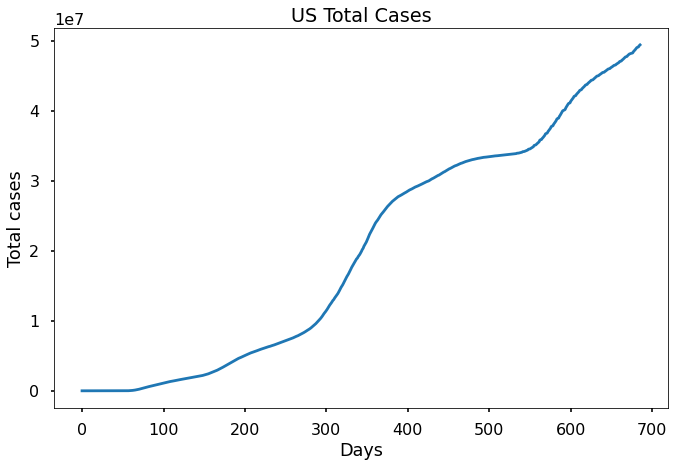

In [5]:
days = data.keys()[4:]
us_data = extract_region_data(data, 'US')
plt.plot(us_data)
plt.title('US Total Cases')
plt.xlabel('Days')
plt.ylabel('Total cases');

We start from day 50ish since the US doesn't have any reported cases until roughly March. It doesn't make sense to include days whose values are zero in our estimate for $\beta$. As discussed, *we're only looking at the first 14 days to estimate* $\beta$. Once we go beyond 14 days, there may be individuals who have recovered from the infection.

Text(0.5, 1.0, 'United States')

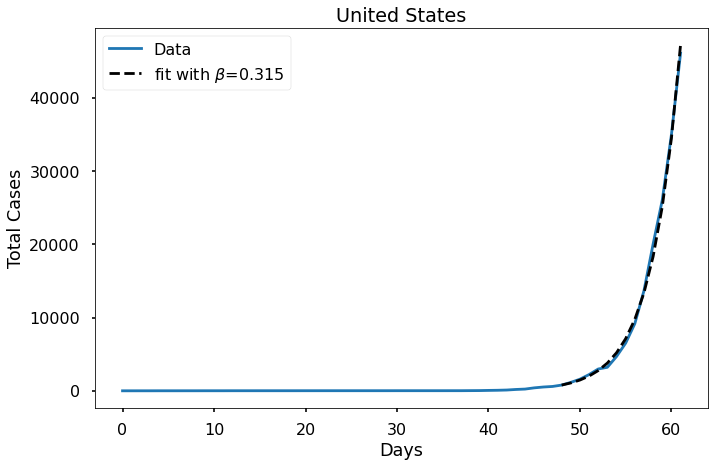

In [8]:
beta = exponential_beta_fit(us_data, 48)
plot_fit(us_data, beta, start=48)
plt.title('United States')

The above fit is actually really good. But, to illustrate the ineffectiveness of the exponential model, we will plot the exponential solution against our real data.

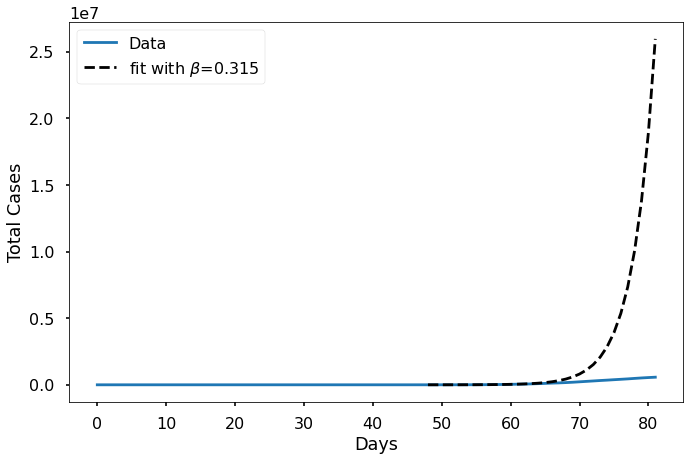

In [9]:
plot_fit(us_data, beta, start=48, n=34)

As we can see, the exponential model increases drastically around day 70. Again, this is because our assumption was that at the beginning of an epidemic (i.e. the first 14 days) the disease spreads at an exponential rate. Furthermore, the US instituted measures to minimize $\beta$ to prevent the spread.

Let's fit data from more countries to get a better idea of what values $\beta$ can take on.

### Fitting More Data

(0.0, 500000.0)

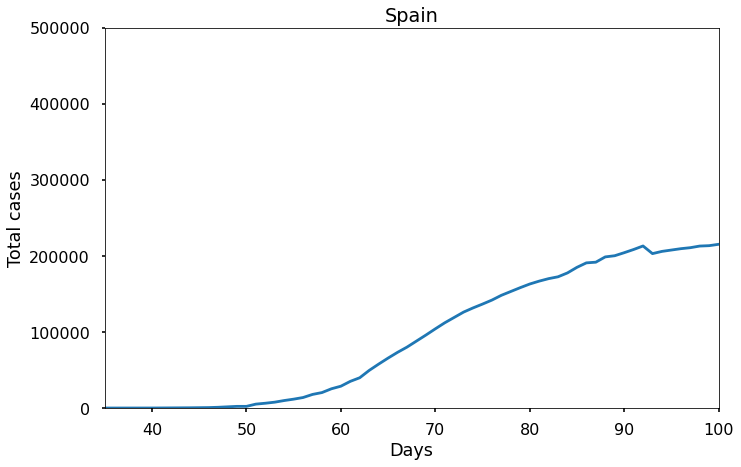

In [10]:
spain_data = extract_region_data(data, 'Spain')
plt.plot(spain_data)
plt.title('Spain')
plt.xlabel('Days')
plt.ylabel('Total cases');
plt.xlim([35, 100])
plt.ylim([0, 500000])

Text(0.5, 1.0, 'Spain')

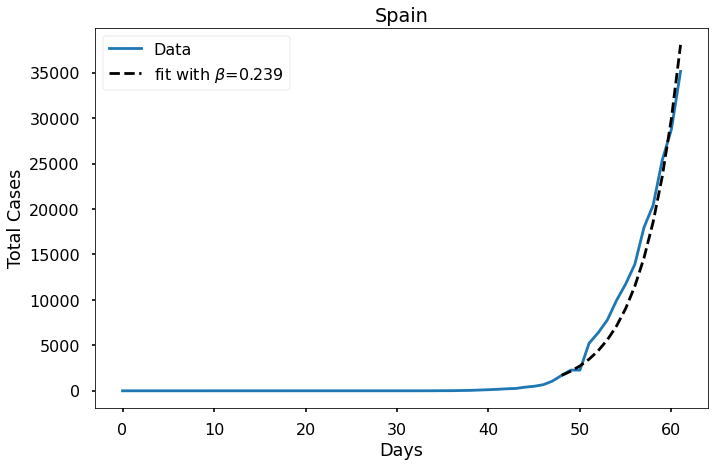

In [11]:
beta = exponential_beta_fit(spain_data, 48)
plot_fit(spain_data, beta, start=48)
plt.title('Spain')

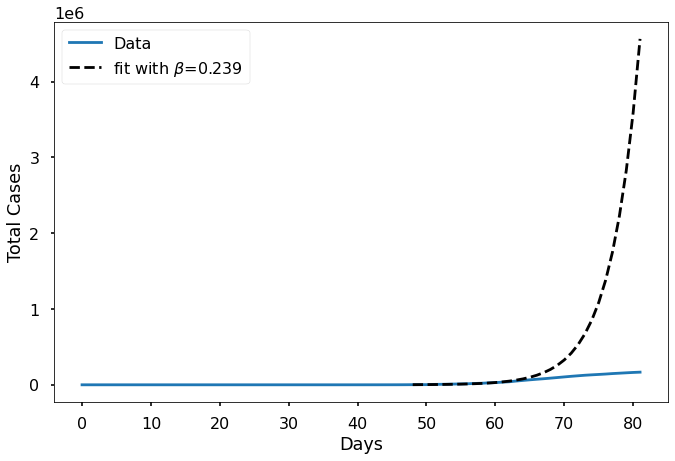

In [44]:
plot_fit(spain_data, beta, start=48, n=34)

(0.0, 110.0)

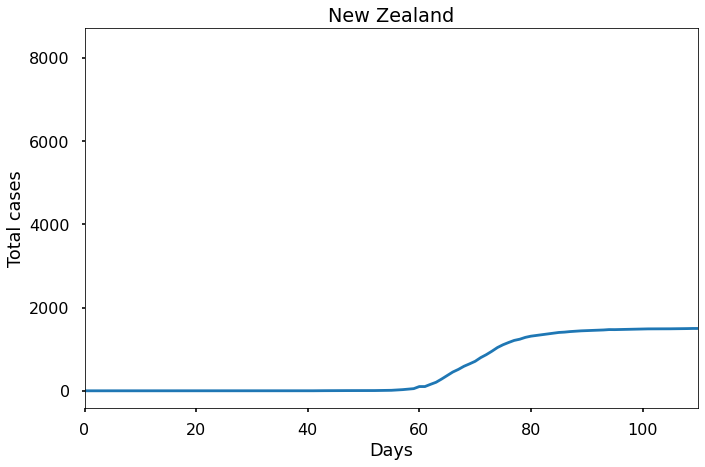

In [12]:
zealand_data = extract_region_data(data, 'New Zealand')
plt.plot(zealand_data)
plt.title('New Zealand')
plt.xlabel('Days')
plt.ylabel('Total cases');
plt.xlim([0, 110])

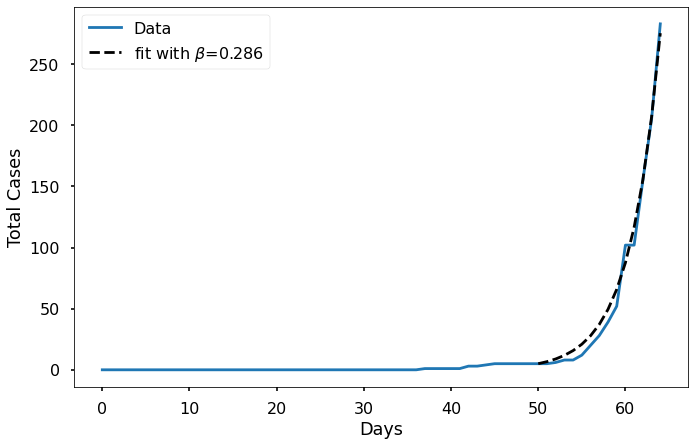

In [13]:
beta = exponential_beta_fit(zealand_data, 50, n=15)
plot_fit(zealand_data, beta, start=50, n=15)

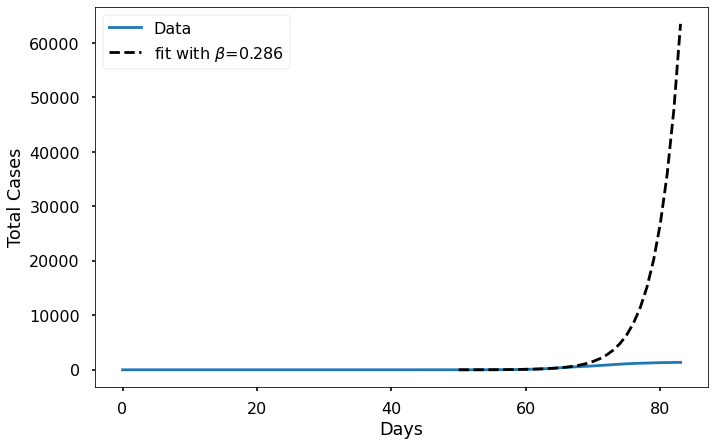

In [59]:
plot_fit(zealand_data, beta, start=50, n=34)

From the above curve fitting, it seems that $\beta$ will range from $0.239 - 0.315$. A reasonable choice for $\beta$ might be $\beta \approx 0.275$. We will be using this estimate in our application of the model.

One thing to note here, is that much like South Korea (from blog post 2), New Zealand has drastically reduced the value of $\beta$. This is because when New Zealand was first struck by COVID, the country responded by going into full lock down for roughly 2-3 months (from end of February to mid May). Social gatherings were banned, nonessential businesses were forced to shut down, and internal travel was restricted. But, this allowed the country to reopen much quicker than other countries (the lockdown was officially declared over in June 2020). This data is all a little out of date, though (the article of reference https://www.brookings.edu/research/policy-and-institutional-responses-to-covid-19-new-zealand/ was written on Jan. 24 2021). With the delta variant, the country might have gone into lockdown again; however, after the lockdown was lifted in June 2020, no new cases were reported for 18 days.

## Making Predictions (without Mitigation)

Now that we've gotten estimates for $\beta$ and $\gamma$, we can begin to make predictions using the SIR model and the following assumptions:

* the COVID-19 pandemic follows the SIR model with parameters $\beta \approx 0.275$ and $\gamma \approx 0.05$.
* no containment measures (e.g. quarantine, mask mandates, social distancing, ect...) are implemented
* the number of confirmed cases at present is about 15% of actual cases (rough estimate based on some expert opinions)

We will note that the following preditions **are not what we actually expected to happen; we are intentionally ignoring mitigation techniques that would have been used**.

First, let's take a look at modeling the global population.

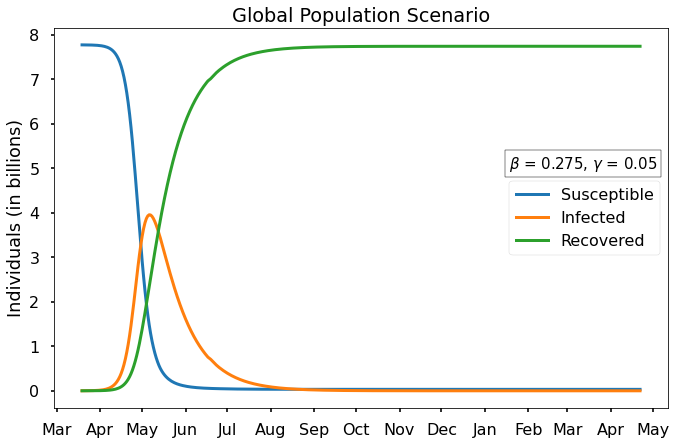

In [123]:
plot_SIR(beta=0.275, gamma=0.05, title='Global Population Scenario')

From the data above we can take away a couple things:

* When the maximum number of infections occurs
* What the maximum number of infections are at one time
* How many people (in total) catch the virus
* How long the pandemic lasts

### When the Max Occurs

We can see that the maximum number of infections occurs roughly around mid-May. At this point, most of the population has been infected, causing the spread to level off and start decreasing. We can expect the infection peak to occur when the fraction of susceptible individuals is $\frac{\gamma}{\beta} = \frac{0.05}{0.275} = 0.18$ or when roughly 82% of the world population has been infected (which includes those who have recovered). This value changes with different values of $\beta$.

### Maximum Number of Infections

The peak from above appears to result in roughly 4 billion concurrent cases. Most of these cases would not be severe, meaning they don't require medical attention. It has been reported that only about 3% of cases are severe enough to require medical attention. However, 3% of 4 billion is approximately 120 million. This means, that without any mitigation techniques there would be *120 million* people that need medical attention all at the same time. Estimates say that each hospital has, on average, 307 beds. There are roughly 16,000 hospitals world wide. That means there are 4.9 million beds available *globally*. About 115 million people would not be able to get medical care in this scenario, and since these cases are severe, it is possible that many of them will succumb to the disease. These numbers also exclude other medical emergencies, such as strokes, heart attacks, cancer patients, car accidents, ect... To put these numbers in perspective, about 75 million people died during World War II. 

### Total Number of Infections

To address the number of people that catch the virus in total, we can see from this model that just about everyone is eventually infected. After about a year, only 50 million individuals are susceptible.

### Pandemic Length

As for how long the pandemic lasts, it's clear to see that after mid-May the pandemic begins to trail off gradually. It's not until about November that the number of infected individuals drops below 1 million. Therefore (in this model), we would expect the severe portion of the pandemic to last several months (from mid-March to mid Fall). Recovered individuals would be able to resume their daily lives in early Fall.

### Variations on the global scenario

Previously we have noted that there is a significant uncertainty in the value of $\beta$. Next, we will look at how the predictions change as $\beta$ is varied between $0.2 - 0.3$:

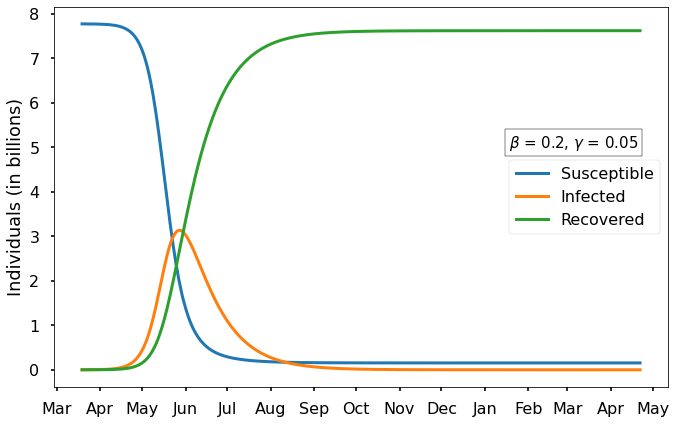

In [34]:
s, i, r = SIR(beta=0.2)
plot_SIR(s, i, r, beta=0.2)

With $\beta = 0.2$, the virus spreads more slowly. The peak instead occurs near the start of June with around 3 billion people being infected. Just like with the previous scenario, the infected count begins to trail off and the number of susceptible individuals drops. Additionally, nearly the entire global population becomes infected, with around 150 million people remaining susceptible and the number of cases doesn't drop below 1 million until November.

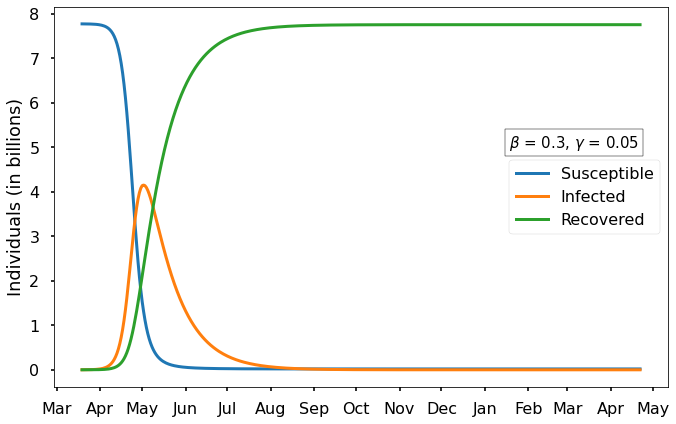

In [33]:
s, i, r = SIR(beta=0.3)
plot_SIR(s, i, r, beta=0.3)

With $\beta = 0.3$, the virus spreads more quickly. The peak occurs near the start of May, exceeding 4 billion infected. The severe period of the epidemic ends a little bit sooner, with the number of infected dropping below 1 million around October. Only 19 million people remain susceptible after a year.

Even with these variations in $\beta$, the picture is more or less the same: the epidemic peaks near the start of summer (mid-May or early June) and will last into Fall.

# Mitigation Effects

As we all know, countries don't really just sit around and wait for epidemics to make their way through the population. Instead, they implement measures to reduce the spread of the disease. This can be done by mandating the wearing of masks, closing schools and workplaces, and quarantining infected individuals and all the people they contacted. 

These measures can effectively be viewed as reducing the value of $\beta$. In other words, reducing the average number of people that an infected individual comes into close contact with in a single day. The factor $\beta$ is a constant in our model, but we can incorporate mitigation techniques in our model by introducing a new factor $q(t) \in [0, 1]$ and multiplying that with $\beta$. Like so:

\begin{align}
\frac{dS}{dt} & = -q(t)\beta I \frac{S}{N} \\
\frac{dI}{dt} & = q(t)\beta I \frac{S}{N}-\gamma I \\
\frac{dR}{dt} & = \gamma I
\end{align}

In this updated model, $q(t)$ essentially represents mitigation techniques used to reduce $\beta$. As an example, if we consider $q = 0$, then that means infected individuals never come into close contact with anyone until they have recovered. In other words, an absolute quarantine. Also consider $q = 1$. This is where no mitigation measures are taken (like in our earlier SIR modeling on the global population). However, in the real world, $q$ would be between these values and will change from country to country (or even state to state here in the US).

Now, what can we consider to be the correct value of $q$? In all honesty, it's a guessing game. Individuals are able to make their own decisions, even though collectively we can agree that mitigating the pandemic is a good thing to do. As such, there are cases where these individuals decide not to quarantine, wear a mask, or protest lockdowns (which, ironically spreads the disease by amplifying $\beta$ for a brief time). We can, however, look at some values of $q$ and explore the impact of implementing mitigation techniques. To make things simple, we will assume that $q < 1$ is achieved through mitigation measures with these measures lasting $N_q$ days. After $N_q$ days, the measures are lifted and $\beta$ returns to its normal value. Now, if $N_q = \infty$ this would be the same as reduing the value of $\beta$.

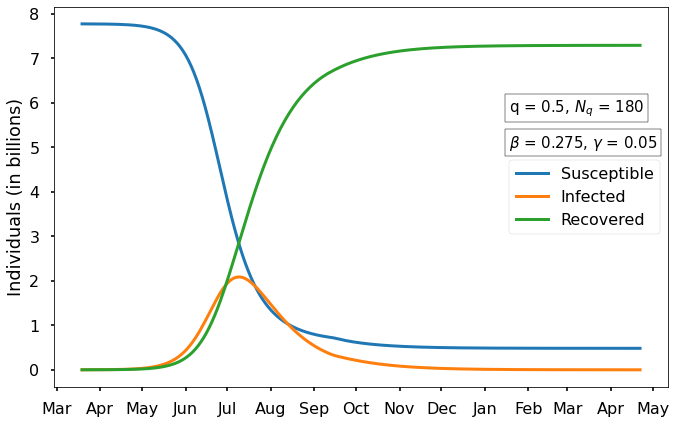

In [32]:
s, i, r = SIR(q=0.5, q_end=180)
plot_SIR(s, i, r, beta=0.275, q=0.5, Nq=180)

Here, we have limited contact by 50% for 180 days. We can see that mitigation has a substantial difference. Before, when there was no mitigation, we saw the peak reach nearly 4 billion near the start of May. With mitigation in place, we have reduced the peak to roughly 2 billion and delayed it till the first couple weeks of July. The number of concurrent infected individuals peters off around November/December (about the start of winter); the number of susceptible individuals stays around 500 million well into the next year though. Like before, it is true that just about every individual gets the infection, but the disease makes its way through the population at a much slower rate (several months, or even years rather than a handful of months).

Now let's look at an even stronger mitigation, by reducing human contact by two-thirds ($q = 0.33$). Measures last for 180 days like before.

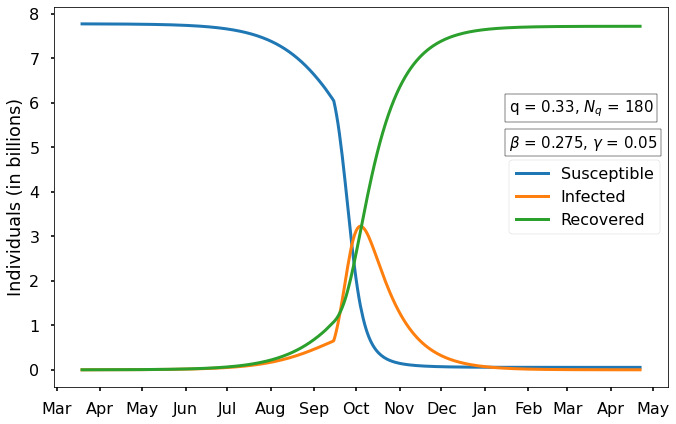

In [31]:
s, i, r = SIR(q=0.33, q_end=180)
plot_SIR(s, i, r, beta=0.275, q=0.33, Nq=180)

As expected, the initial growth is even slower. But, there's an interesting consequence: the infection peaks around the start of October and is even worse than before. This is a couple weeks after the restrictions have been lifted (around the middle of September). The result might seem counter intuitive, but it actually makes sense. Since we reduced human contact quite substantially, the number of infected individuals grew quite slowly. But, that means that the number of susceptible individuals remained at a higher value and was still quite substantial when the restrictions were lifted, allowing the disease to spread as if no restrictions were in place. Really, all this did was change when the peak happened.

Now, lets see if we can apply the model to the United States population. We simply change the total population count from 7.7 billion to 330 million and use the $\beta$ value we found specifically for the US data (which was 0.315). We also allow mitigation effects to not take place until after a set amount of time. Mitigation effects last for 90 days and start taking effect after the first two weeks. We are specifically doing it this way, because the US didn't start mitigation until *after* COVID had already struck. This should (hopefully) make it more realistic.

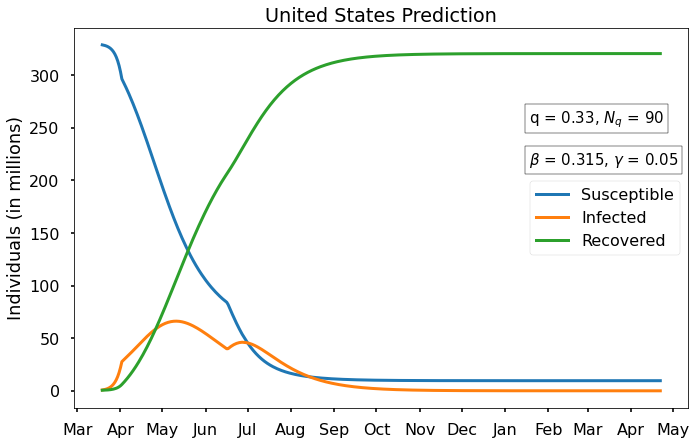

In [6]:
s, i, r = SIR(beta=0.315, N=330000000, q=0.33, q_start=14, q_end=90)
plot_SIR(s, i, r, beta=0.315, q=0.33, Nq=90, 
        reduction=1.e6, beta_gamma_loc=215, q_Nq_loc=255,
        ylabel='Individuals (in millions)', title='United States Prediction')

As we can see, the epidemic was going to grow rather quickly just based off of how the graph looks for the first 14 days. Then, mitigation takes effect and the curve flattens slightly. After mitigation effects end (about half way through June), we get a smaller, second peak that gradually trails off around October. About 20 million people are still susceptible into the next year. 

Now, others who lived through this time period know that from about mid-March to about late June that people were wearing masks and trying to stay 6 feet apart. People weren't going out to eat and the pandemic was being taken seriously. But once July hit, businesses, schools, and restaurants began opening back up. I remember, rather distinctly, that cases were steadily climbing before reaching an all time high and things being even worse than before. 

# Interactive Example Using Idaho Data

Here we look at applying our SIR model to Idaho data. First, we will find an approximation for $\beta$ to make it more accurate.

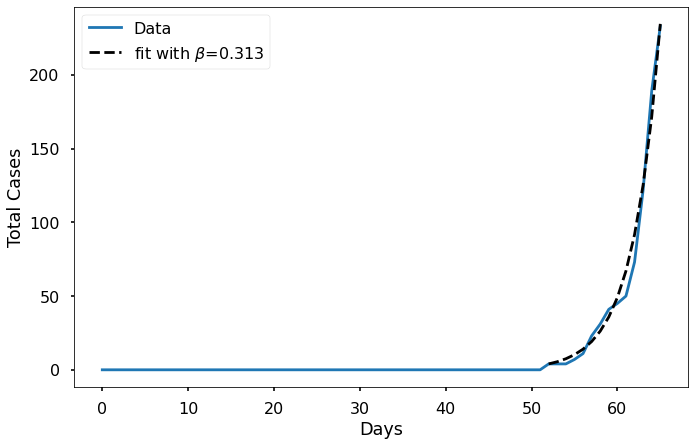

In [87]:
data = extract_idaho_data()
beta = exponential_beta_fit(data, 52)
plot_fit(data, beta, start=52, n=14)

Here we have $\beta = 0.313$, which is what we'll be using for applying the SIR model. Instead of showing the three population groups like before, we'll instead be plotting the number of infected against actual reported numbers for the first 180 days of the epidemic.

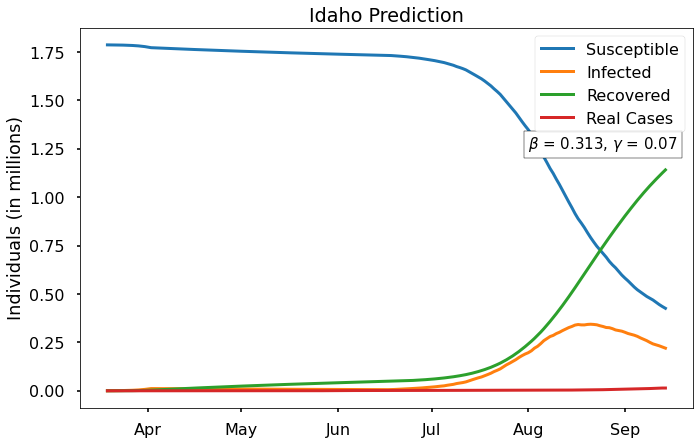

In [111]:
s, i, r = SIR(beta=0.313, gamma=0.07, N=1787000, total_cases=75, total_recovered=15, days=180,
              q=0.2, q_start=14, q_end=90, random_mitigation=True)
plot_SIR(s, i, r, beta=0.313, gamma=0.07, T=180, cases=data,
        reduction=1.e6, beta_gamma_loc=1.25, horizontal_loc=18475,
        ylabel='Individuals (in millions)', title='Idaho Prediction')



# SEIR Modeling

One of the limitations with the SIR model is that it doesn't take into account the amount of time required to become infectious after being exposed. In other words, there is a window of time where an individual has been exposed to the disease, but they are not yet infectious to others.

The model SEIR introduces a new compartment E with this idea in mind. Susceptible individuals who have been exposed move into this population and exit it after they are fully contagious to others (i.e. infected). This model is presented in the differential equations below:

\begin{align}
\frac{dS}{dt} & = -\frac{\beta S I}{N} \\
\frac{dE}{dt} & = \frac{\beta S I}{N} - \sigma E \\
\frac{dI}{dt} & = \sigma E - \gamma I \\
\frac{dR}{dt} & = \gamma I
\end{align}

As with the SIR model, the differential equations for $S$ and $R$ are the same. Instead, we've introduced latency here with $E$, where an individual does not start spreading the disease after an incubation period for the disease (which is shown above with $\sigma$). Like with $\gamma$ in the SIR model, the incubation period is the reciprocal of the time it takes (in days) for the individual to no longer just be exposed, but infected.

COVID has an incubation period that can last from 2-14 days, giving us a range of roughly $0.07 - 0.5$. Estimates gathered at the start of the pandemic state that the median is about 5 days and more than 95% will develop symptoms within 11 days. With this in mind, a thoughtful estimate for $\sigma$ could be $\sigma = \frac{1}{5} = 0.2$ which is what we'll be using for our models.

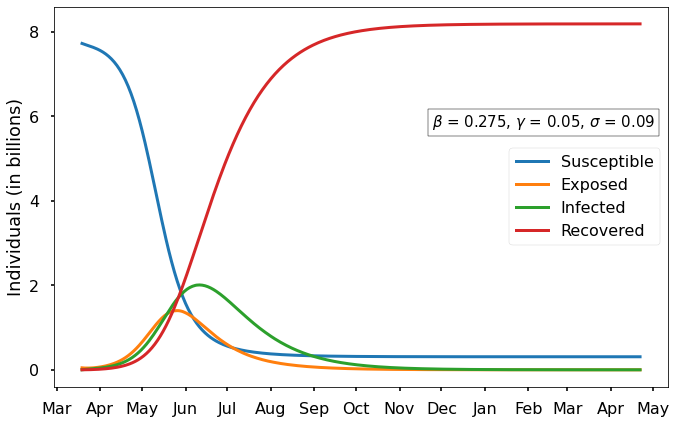

In [14]:
s, e, i, r = SEIR(beta=0.275, sigma=0.09)
plot_SEIR(s, e, i, r, sigma=0.09, beta=0.275)

# Functions

In [4]:
def extract_region_data(data, region):
    days = data.keys()[4:]
    tophalf = data.iloc[:]
    rows = tophalf['Country/Region'].isin([region])
    region_data = [tophalf[day][rows].sum() for day in days]
    return region_data

def extract_idaho_data():
    df = pd.read_csv("src/idaho_confirmed.csv")
    days = df.keys()[4:]
    data = [df[day].sum() for day in days]
    return data

def exponential_beta_fit(cases, start, n=14):
    dd = np.arange(start + n)
    def resid(beta):
        prediction = cases[start] * np.exp(beta * (dd-start))
        return prediction[start:start+n] - cases[start:start+n]
    
    soln = optimize.least_squares(resid, 0.2)
    beta = soln.x[0]
    return beta

def plot_fit(cases, beta, start, n=14):
    length = start + n
    dd = np.arange(length)
    plt.plot(cases[:length])
    prediction = cases[start] * np.exp(beta * (dd-start))
    plt.plot(dd[start:length], prediction[start:length], '--k')
    plt.legend(['Data', r'fit with $\beta$={:.3f}'.format(beta)])
    plt.xlabel('Days')
    plt.ylabel('Total Cases')

def SIR(beta=0.275, gamma=0.05, N=7770000000, 
        total_cases=199258.0, total_recovered=81972.0, confirmed_fraction=0.15,
        days=400, q=1, q_start=0, q_end=0, random_mitigation=False):
    du = np.zeros(3)
    u0 = np.zeros(3)
    
    def f(t, u):
        q_val = q if t >= q_start and t < q_end else 1
        if random_mitigation and t >= q_end:
            q_val = random.uniform(q, 0.75) if random.random() > 0.1 else 1
        du[0] = -q_val * beta * u[1] * u[0]/N
        du[1] = q_val * beta * u[1] * u[0]/N - gamma * u[1]
        du[2] = gamma * u[1]
        return du
    
    # number of confirmed cases as reported globally in late March 2020
    total_cases = total_cases / confirmed_fraction 
    # number of confirmed recovered individuals globally in late March 2020
    u0[2] = total_recovered / confirmed_fraction
    u0[1] = total_cases - u0[2] # initial infected count
    u0[0] = N - u0[1] - u0[2] # initial susceptible count
    
    times = np.arange(0, days)
    solution = solve_ivp(f, [0, days], u0, t_eval=times, method='RK23')
    S = solution.y[0,:]
    I = solution.y[1,:]
    R = solution.y[2,:]

    return S, I, R

def plot_SIR(s, i, r, beta=0.25, gamma=0.05, T=400, 
             q=None, Nq=None, reduction=1.e9,
             beta_gamma_loc=5, q_Nq_loc=5.8,
             horizontal_loc=18645, cases=None,
             start_date='2020-03-19', 
             title=None, ylabel='Individuals (in billions)'):
    start = dates.datestr2num(start_date)
    my_dates = np.arange(T) + start

    plt.plot_date(my_dates, s / reduction, '-', lw=3)
    plt.plot_date(my_dates, i / reduction, '-', lw=3)
    plt.plot_date(my_dates, r / reduction, '-', lw=3)
    
    if cases:
        plt.plot_date(my_dates, pd.Index(cases)[:T] / reduction, '-', lw=3)
    
    ax = plt.gca()
    ax.xaxis.set_major_locator(dates.MonthLocator())
    ax.xaxis.set_major_formatter(dates.DateFormatter('%b'))
    legend = ['Susceptible', 'Infected', 'Recovered']
    if cases:
        legend.append('Real Cases')
    plt.legend(legend)
    plt.ylabel(ylabel)
    plt.text(horizontal_loc, beta_gamma_loc, r'$\beta$ = {}, $\gamma$ = {}'.format(beta, gamma),
            fontsize=15, bbox=dict(facecolor='white', alpha=1.0))
    if q and Nq:
        plt.text(horizontal_loc, q_Nq_loc, r'q = {}, $N_q$ = {}'.format(q, Nq),
                fontsize=15, bbox=dict(facecolor='white', alpha=1.0))
    if title:
        plt.title(title)
    plt.show()

def SEIR(beta=0.275, gamma=0.05, sigma=0.2, N=7770000000, confirmed_fraction=0.15,
        days=400, q=1, q_start=0, q_end=0):
    du = np.zeros(4)
    u0 = np.zeros(4)
    
    def f(t, u):
        q_val = q if t >= q_start and t < q_end else 1
        du[0] = -q_val * beta * u[1] * u[0] / N
        du[1] = q_val * beta * u[2] * u[0] / N - sigma * u[1]
        du[2] = sigma * u[1] - gamma * u[2]
        du[3] = gamma * u[2]
        return du
    
    # number of confirmed cases as reported globally in late March 2020
    total_cases = 199258. / confirmed_fraction 
    # number of confirmed recovered individuals globally in late March 2020
    u0[3] = 81972. / confirmed_fraction
    u0[2] = total_cases - u0[3] # initial infected count
    u0[1] = u0[2] * 60 # initial exposed count
    u0[0] = N - u0[1] - u0[2] - u0[3] # initial susceptible count
    
    times = np.arange(0, days)
    solution = solve_ivp(f, [0, days], u0, t_eval=times, method='RK23')
    S = solution.y[0,:]
    E = solution.y[1,:]
    I = solution.y[2,:]
    R = solution.y[3,:]

    return S, E, I, R

def plot_SEIR(s, e, i, r, beta=0.25, gamma=0.05, sigma=0.2, T=400, 
              q=None, Nq=None, reduction=1.e9,
              beta_gamma_loc=5.75, q_Nq_loc=5.8,
              start_date='2020-03-19', 
              title=None, ylabel='Individuals (in billions)'):
    start = dates.datestr2num(start_date)
    my_dates = np.arange(T) + start

    plt.plot_date(my_dates, s / reduction, '-', lw=3)
    plt.plot_date(my_dates, e / reduction, '-', lw=3)
    plt.plot_date(my_dates, i / reduction, '-', lw=3)
    plt.plot_date(my_dates, r / reduction, '-', lw=3)
    
    ax = plt.gca()
    ax.xaxis.set_major_locator(dates.MonthLocator())
    ax.xaxis.set_major_formatter(dates.DateFormatter('%b'))
    plt.legend(['Susceptible', 'Exposed', 'Infected', 'Recovered'])
    plt.ylabel(ylabel)
    plt.text(18590, beta_gamma_loc, 
             r'$\beta$ = {}, $\gamma$ = {}, $\sigma$ = {}'.format(beta, gamma, sigma),
            fontsize=15, bbox=dict(facecolor='white', alpha=1.0))
    if q and Nq:
        plt.text(18590, q_Nq_loc, r'q = {}, $N_q$ = {}'.format(q, Nq),
                fontsize=15, bbox=dict(facecolor='white', alpha=1.0))
    if title:
        plt.title(title)
    plt.show()